9 20
9 20
12 20
12 20


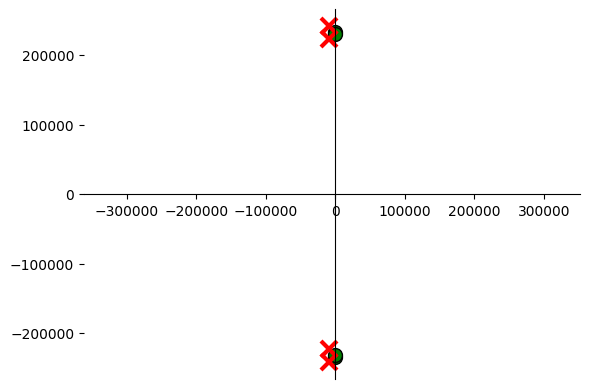

poles:
wo=241736.49195856144; xi= 0.0393963375601905; Q= 12.6915350757184
wo=241736.49195856144; xi= 0.0393963375601905; Q= 12.6915350757184
wo=223220.41681294708; xi= 0.03939633756019089; Q= 12.691535075718274
wo=223220.41681294708; xi= 0.03939633756019089; Q= 12.691535075718274
zeros:
wo=233599.46151146572; xi= 0; Q= inf
wo=233599.46151146572; xi= 0; Q= inf
wo=230995.91131224085; xi= 0; Q= inf
wo=230995.91131224085; xi= 0; Q= inf


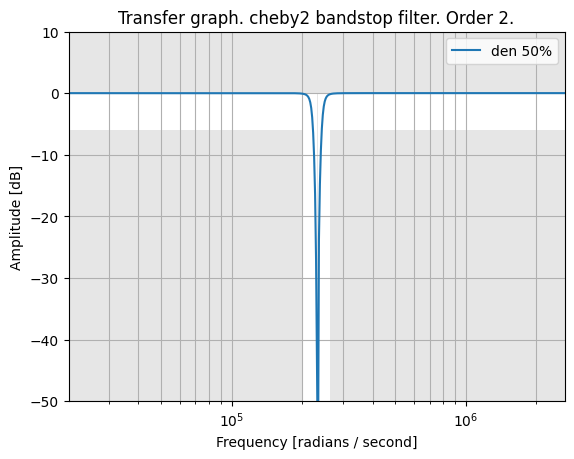

TransferFunctionContinuous(
array([1.00000000e+00, 0.00000000e+00, 1.07927819e+11, 0.00000000e+00,
       2.91173777e+21]),
array([1.00000000e+00, 3.66351987e+04, 1.08598888e+11, 1.97685439e+15,
       2.91173777e+21]),
dt: None
)


In [4]:
from cmath import pi
from backend import *
import numpy as np

""" 

    Tipos de filtro:
    
    'butter'
    'cheby'
    'cheby2'
    'cauer'
"""

"""
filter = 'cheby2'
filter_type = 'lowpass'
Wpass = 150
Watt = 300
Gp = -3
Ga = -50
deg = 0.5
"""
"""
filter = 'cheby2'
filter_type = 'highpass'
Watt = 150
Wpass = 300
Gp = -3
Ga = -50
deg = 0.5
"""
"""
filter = 'cheby2'
filter_type = 'bandpass'
Watt = [100,350]
Wpass = [10,300]
Gp = -3
Ga = -50
deg = 0.5
"""

filter = 'cheby2'
filter_type = 'bandstop'
Wpass = [2*np.pi*(37e3-5e3),2*np.pi*(37e3+5e3)]
Watt = [2*np.pi*(37e3-300),2*np.pi*(37e3+300)]
Gp = -6
Ga = -40
deg = 0.5


order, Wn = get_min_order(filter, Wpass, Watt, -Gp, -Ga)

b, a = get_filter(filter,filter_type, order, Wn,  Wpass, Watt, Gp,Ga,0.5)
return_p_z(b,a)

"""Hay que elegir entre el grafico d etoda la vida, o de atenuación (al revés)
los parametros son 'attenuation' y 'standard' """
graph_filter('standard',filter,filter_type, order, Wpass, Watt, Gp,Ga,0.5,b,a)
print(signal.TransferFunction(b,a))
